In [2]:
!pip install -Uqq portalocker>=2.0.0
!pip install -Uqq plotly
!pip install -qq dash

zsh:1: 2.0.0 not found


In [5]:
!pip install matplotlib

     |████████████████████████████████| 7.8 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 3.9 MB/s eta 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     |████████████████████████████████| 106 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 5.7 MB/s eta 0:00:011
     |████████████████████████████████| 249 kB 10.5 MB/s eta 0:00:01


In [3]:
import numpy as np

In [4]:
print(np.__version__)

1.26.3


In [43]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


In [6]:
# Define helper functions

def plot(cost, acc):
    fig, ax1 = plt.subplots()
    colour = 'tab:red'
    ax1.plot(cost, color=colour)
    ax1.set_xlabel('epoch', color=colour)
    ax1.set_ylabel('total loss', color=colour)
    ax1.tick_params(axis='y', color=colour)

    ax2 = ax1.twinx()
    colour = 'tab:blue'
    ax2.set_ylabel('accuracy', color=colour)
    ax2.plot(acc, color=colour)
    ax2.tick_params(axis='y', color=colour)
    
    fig.tight_layout()

    plt.show()

## Import dataset

In [12]:
train_iter = iter(AG_NEWS(split='train'))

In [9]:
y, text = next((train_iter))
print(y, text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [10]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [11]:
# Find all classes

num_class = len(set([label for (label, text) in train_iter]))
num_class

4

In [13]:
# Create tokens

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [14]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

In [15]:
vocab(["age", "hello"])

[2120, 12544]

## Dataset

In [16]:
# Split the dataset into training and testing iterators

train_iter, test_iter = AG_NEWS()

In [17]:
# Convert the training and testing iterators to map-style datasets

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

In [18]:
# Determine the number of samples to be used for training and validation (5% for validation)

num_train = int(len(train_dataset) * 0.95)

In [19]:
# Randomly split the training dataset into training and validation datasets using 'random_split'AG_NEWS

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [20]:
device = torch.device("cpu")
device

device(type='cpu')

## Data loader

Prepare the text processing pipeline with the tokenizer and vocabulary. 

The text adn label pipelines are used to process the raw data strings from the dataset iterators.

In [21]:
# Tokenize the input and get token indices
def text_pipeline(x):
    return vocab(tokenizer(x))

# Make sure that the labels start at zero
def label_pipeline(x):
    return int(x) - 1

The `collate_fn` is used with data loaders to customise the way batches are created from individual samples.

In [22]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

Convert the dataset objects to a data loader by applying the collate function.

In [23]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [24]:
label, text, offsets = next(iter(valid_dataloader))
label, text, offsets

(tensor([2, 1, 1, 2, 0, 3, 3, 2, 0, 1, 0, 2, 2, 2, 1, 0, 3, 2, 1, 2, 2, 0, 1, 0,
         3, 2, 2, 3, 0, 3, 2, 2, 1, 0, 0, 3, 1, 3, 1, 2, 3, 3, 3, 0, 0, 1, 0, 0,
         1, 0, 1, 1, 0, 3, 0, 2, 3, 0, 3, 3, 2, 2, 1, 0]),
 tensor([ 558,  150, 2599,  ..., 1613,  475,    1]),
 tensor([   0,   26,   74,  114,  162,  205,  226,  254,  300,  338,  384,  441,
          493,  532,  568,  597,  668,  694,  743,  783,  820,  896,  938,  975,
         1024, 1065, 1136, 1191, 1232, 1285, 1326, 1368, 1407, 1457, 1503, 1533,
         1586, 1634, 1672, 1715, 1763, 1802, 1847, 1901, 1938, 1980, 2016, 2061,
         2126, 2168, 2223, 2281, 2318, 2358, 2394, 2436, 2483, 2544, 2575, 2635,
         2727, 2766, 2822, 2870]))

## Neural network

In [25]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [26]:
emsize = 64

In [27]:
vocab_size = len(vocab)
vocab_size

95811

In [28]:
num_class

4

In [29]:
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [30]:
predicted_label = model(text, offsets)

In [31]:
predicted_label.shape

torch.Size([64, 4])

In [32]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(1).item() + 1]

In [33]:
predict("I like sports", text_pipeline)

'World'

In [34]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
        
    return total_acc / total_count

In [35]:
evaluate(test_dataloader)

0.2293421052631579

## Train the model

In [36]:
LR = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [37]:
EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss += loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

100%|██████████| 10/10 [01:20<00:00,  8.05s/it]


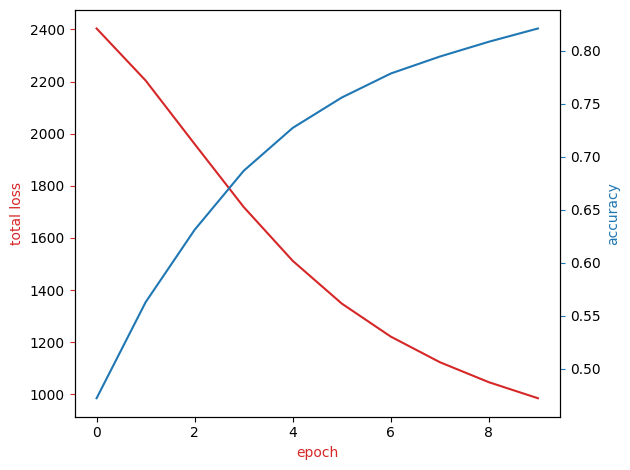

In [38]:
plot(cum_loss_list,acc_epoch)

In [39]:
evaluate(test_dataloader)

0.8106578947368421

## Generating a 3D t-SNE visualisation of embeddings using Plotly

It demonstrates how words that are similar to each other are positioned closer together.

In [40]:
import numpy as np

In [40]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),
        colorscale="Viridis",
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualisation of Embeddings",
                   scene=dict(xaxis_title="Dimension 1",
                              yaxis_title="Dimension 2",
                              zaxis_title="Dimension 3"))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [41]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [44]:
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</h3>
    <h4>The category of the news article: Sports</h4>
</div>
